In [1]:
%load_ext autoreload
%autoreload 2

# Simple representation space tests with an FCN


## Imports

In [2]:
from typing import Optional, List, Callable, Dict, Any, Tuple, Union
from functools import partial
import logging
import os
import ast
import json

import numpy as np
import haiku as hk
import jax
import jax.numpy as jnp
import equinox as eqx
import optax  # https://github.com/deepmind/optax
import torch  # https://pytorch.org
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score

import wandb

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'cpu')

from synbio_morpher.utils.data.data_format_tools.common import write_json
from synbio_morpher.utils.misc.numerical import make_symmetrical_matrix_from_sequence
from synbio_morpher.utils.misc.string_handling import convert_liststr_to_list
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.results.analytics.naming import get_true_names_analytics, get_true_interaction_cols

jax.devices()

I0000 00:00:1696872101.122291  389694 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


[gpu(id=0)]

## Load data

In [3]:
fn = '../data/processed/ensemble_mutation_effect_analysis/2023_07_17_105328/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
data.drop(columns=['Unnamed: 0'], inplace=True)
# for c in get_true_interaction_cols(data, interaction_attr='binding_sites_idxs', remove_symmetrical=True) + get_true_interaction_cols(
#         data, interaction_attr='binding_site_group_range', remove_symmetrical=True):
#     data[c] = data[c].map(ast.literal_eval)

## Model: network of fully connected layers

In [4]:
# https://coderzcolumn.com/tutorials/artificial-intelligence/haiku-cnn

class FCN(hk.Module):

    def __init__(self, layer_sizes: List[int], n_head: int):
        super().__init__(name="FCN")
        self.layers = self.create_layers(layer_sizes, n_head)
        
        
    def create_layers(self, layer_sizes: List[int], n_head: int):
        sizes = layer_sizes + [n_head]
        l = []
        for i, s in enumerate(sizes):
            if l:
                l.append(jax.nn.relu)
                if np.mod(i, 2) == 0:
                    l.append(jax.nn.sigmoid)
            # if sj == n_head:
            #     l.append(eqx.nn.Dropout(p=0.4))
            
            # He initialisation
            l.append(
                hk.Linear(s, w_init=hk.initializers.VarianceScaling(scale=2.0))
            )
        l.append(jax.nn.log_softmax)
        return l
        

    def __call__(self, x: Float[Array, " num_interactions"], inference: bool = False, seed: int = 0) -> Float[Array, " n_head"]:
        for i, layer in enumerate(self.layers):
            kwargs = {} if not type(layer) == eqx.nn.Dropout else {
                'inference': inference, 'key': jax.random.PRNGKey(seed)}

            x = layer(x, **kwargs)
            
            # wandb.log({f'emb_{i}_{type(layer)}': x})
        return x
    
    
def FCN_fn(x, **kwargs):
    model = FCN(**kwargs)
    return model(x)

## Losses

In [5]:
def loss_fn(
    params, rng,
    model: FCN, x: Float[Array, " batch n_interactions"], y: Int[Array, " batch"], 
    l2_reg_alpha: Float,
    loss_type: str = 'categorical'
) -> Float[Array, ""]:
    
    pred_y = model.apply(params, rng, x)
    if loss_type == 'categorical':
        loss = cross_entropy(y, pred_y, num_classes=pred_y.shape[-1])
    else:
        loss = mse_loss(y, pred_y)

    # Add L2 loss
    # loss += sum(
    #     l2_loss(w, alpha=l2_reg_alpha) 
    #     for w in jax.tree_util.tree_leaves(params)
    # )
    return loss


def l2_loss(weights, alpha):
    return alpha * (weights ** 2).mean()


def cross_entropy(y: Int[Array, " batch"], pred_y: Float[Array, "batch 10"], num_classes: int):
    one_hot_actual = jax.nn.one_hot(y, num_classes=num_classes)
    return optax.softmax_cross_entropy(pred_y, one_hot_actual).sum()


def mse_loss(y, pred_y):
    return jnp.mean(jnp.square(pred_y - y))


def update_params(optimiser, params, grads):
    updates, optimizer_state = optimiser.update(grads, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params


@eqx.filter_jit
def compute_accuracy(
    params, rng, model: FCN, x: Float[Array, "batch num_interactions"], y: Int[Array, " batch n_head"]
) -> Float[Array, ""]:
    pred_y = model.apply(params, rng, x)
    pred_y = jnp.argmax(pred_y, axis=1)
    return jnp.mean(y == pred_y)


def compute_accuracy_regression(
    params, rng, model: FCN, x, y
):
    pred_y = model.apply(params, rng, x)
    err = np.sqrt(np.mean(jnp.square(pred_y - y)))



## Hyperparameters

In [28]:
BATCH_SIZE = 128
N_BATCHES = 900
TOTAL_DS = BATCH_SIZE * N_BATCHES
TRAIN_SPLIT = int(0.8 * TOTAL_DS)
TEST_SPLIT = TOTAL_DS - TRAIN_SPLIT
LEARNING_RATE = 5e-4
LEARNING_RATE_SCHED = 'cosine_decay'
# LEARNING_RATE_SCHED = 'constant'
WARMUP_EPOCHS = 20
L2_REG_ALPHA = 0.01
EPOCHS = 1000
PRINT_EVERY = EPOCHS // 30
SEED = 1
INPUT_SPECIES = 'RNA_1'

# MLP Architecture
LAYER_SIZES = [50, 50, 50]
USE_CATEGORICAL = True

loss_fn = partial(loss_fn, loss_type = 'categorical' if USE_CATEGORICAL else 'mse')

n_samples = len(data['sample_name'].unique())

rng = jax.random.PRNGKey(SEED)
# rng, subkey = jax.random.split(rng, 2)

## Initialise

### Input

To make sure that there is little repetition in the dataset, the uniqueness of each sample will be judged. For genetic circuits,there is a lot of sparsity, as most biological sequences do not interact. Therefore, there may be an overrepresentation of some circuit topologies. 

In [29]:
def custom_round(x, base=5):
    return base * round(x/base)


def convert_to_scientific_exponent(x, numerical_resolution: dict):
    exp_not = f'{x:.0e}'.split('e')
    resolution = numerical_resolution[int(exp_not[1])]
    base = int(10 / resolution)
    pre = custom_round(int(exp_not[0]), base=base)
    return int(exp_not[1]) + pre / 10


def drop_duplicates_keep_first_n(df, column, n):
    """ GCG """
    indices = df[df.duplicated(subset=column, keep=False)].groupby(
        column).head(n).index
    all_duplicates_indices = df[df.duplicated(subset=column, keep=False)].index
    to_drop = list(set(all_duplicates_indices) - set(indices))
    df2 = df.drop(to_drop)
    return df2


vectorized_convert_to_scientific_exponent = np.vectorize(
    convert_to_scientific_exponent)
filt = data['sample_name'] == INPUT_SPECIES
numerical_resolution = 2

# Balance the dataset
df = drop_duplicates_keep_first_n(data[filt], get_true_interaction_cols(data, 'energies', remove_symmetrical=True), n=200)
df['sensitivity_wrt_species-6'] = df['sensitivity_wrt_species-6'].round(np.abs(int(f'{df["sensitivity_wrt_species-6"].min():.0e}'.split('e')[1]))-1)
df = drop_duplicates_keep_first_n(df, column='sensitivity_wrt_species-6', n=200)


In [30]:
x = df[get_true_interaction_cols(data, 'energies', remove_symmetrical=True)].iloc[:TOTAL_DS].values
x = np.abs(x)
# x = jax.tree_util.tree_map(vectorized_convert_to_scientific_exponent, x).astype(jnp.float32)
np.random.shuffle(x)

y = df['sensitivity_wrt_species-6'].iloc[:TOTAL_DS].to_numpy()
y_map = {k: numerical_resolution for k in np.arange(int(f'{y[y != 0].min():.0e}'.split('e')[1])-1, np.max([int(f'{y.max():.0e}'.split('e')[1])+1, 0 +1]))}

y_map[-6] = 1
y_map[-5] = 1
y_map[-4] = 4
y_map[-3] = 2
y_map[-1] = 3
y = jax.tree_util.tree_map(partial(vectorized_convert_to_scientific_exponent, numerical_resolution=y_map), y)
if USE_CATEGORICAL:
    y = np.interp(y, sorted(np.unique(y)), np.arange(len(sorted(np.unique(y))))).astype(int)
np.random.shuffle(y)

N_HEAD = len(np.unique(y)) if USE_CATEGORICAL else 1


if x.shape[0] < TOTAL_DS:
    print(
        f'WARNING: The filtered data is not as large as the requested total dataset size: {x.shape[0]} vs. requested {TOTAL_DS}')

#### Scale input

In [9]:
xscaler, yscaler = MinMaxScaler(), MinMaxScaler()
x = xscaler.fit_transform(x)
# y = yscaler.fit_transform(y)
# inverse = scaler.inverse_transform(normalized)

# xscaler, yscaler = StandardScaler(), StandardScaler()
# x = xscaler.fit_transform(x)
# y = yscaler.fit_transform(y)
# inverse = scaler.inverse_transform(standardized)

In [10]:
x_train, y_train = x[:TRAIN_SPLIT], y[:TRAIN_SPLIT]
x_val, y_val = x[-TEST_SPLIT:], y[-TEST_SPLIT:]

Text(0.5, 1.0, 'y')

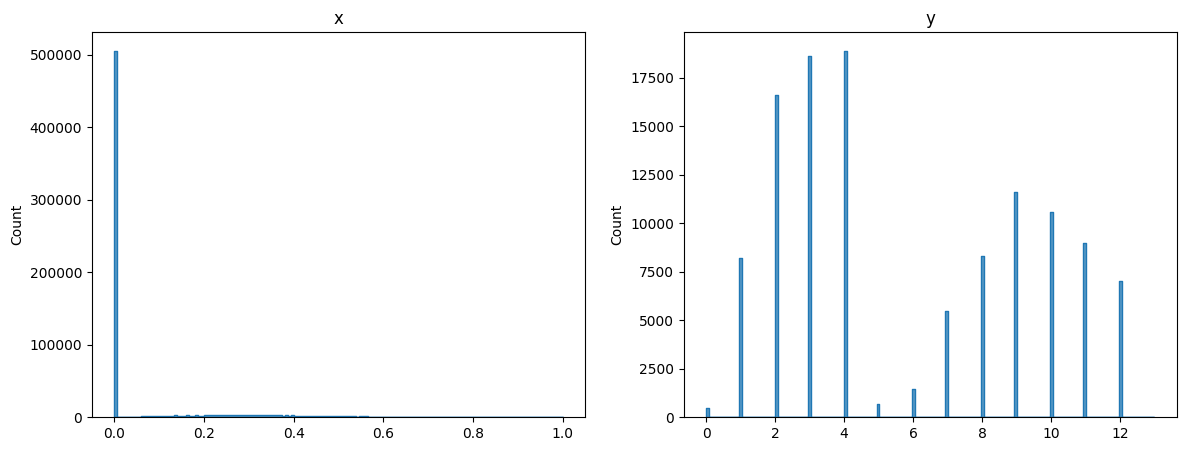

In [11]:
plt.figure(figsize=(2*7, 5))
ax = plt.subplot(1,2,1)
sns.histplot(x=x.flatten(), element='step', bins=150)
plt.title('x')
ax = plt.subplot(1,2,2)
# y = data[filt]['sensitivity_wrt_species-6'].iloc[:TOTAL_DS].to_numpy() 
# y = data[filt]['initial_steady_states'].iloc[:TOTAL_DS].to_numpy()
sns.histplot(x=(y.flatten()), element='step', bins = 150)
plt.title('y')


In [12]:

# Calculate the sparsity of the dataset
num_zeros = (x == 0).sum()
total_elements = np.size(x)
sparsity = num_zeros / total_elements

print(f"The sparsity of the dataset x: {sparsity:.4f}")

num_zeros = (y == 0).sum()
total_elements = np.size(y)
sparsity = num_zeros / total_elements

print(f"The sparsity of the dataset y: {sparsity:.4f}")


The sparsity of the dataset x: 0.7199
The sparsity of the dataset y: 0.0041


Text(0.5, 1.0, 'y')

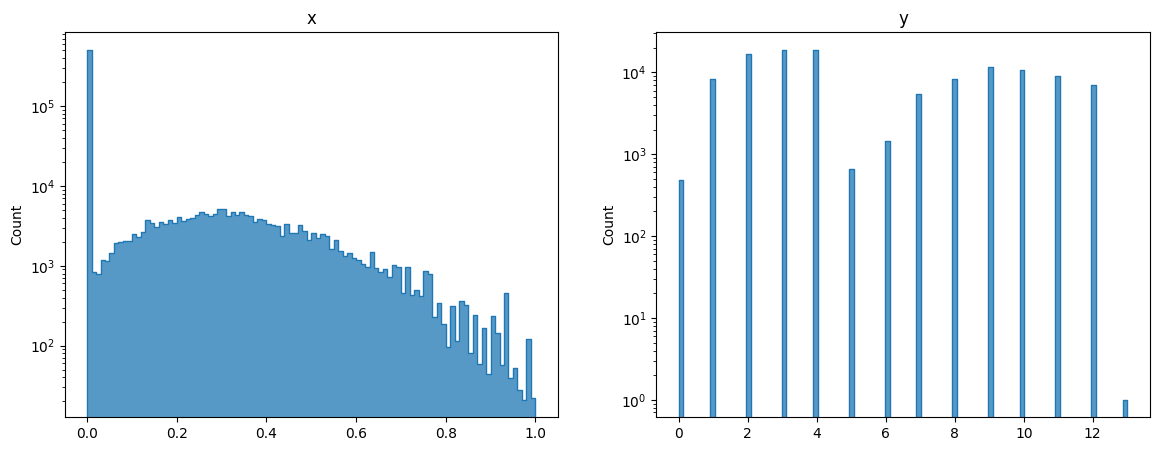

In [13]:
plt.figure(figsize=(2*7, 5))
ax = plt.subplot(1,2,1)
sns.histplot(x=x.flatten(), element='step', log_scale=[False, True], bins=100)
plt.title('x')
ax = plt.subplot(1,2,2)
sns.histplot(x=y.flatten(), element='step', log_scale=[False, True], bins=100)
plt.title('y')


### Initialise model

In [14]:
model = hk.transform(partial(FCN_fn, layer_sizes=LAYER_SIZES, n_head=N_HEAD))

params = model.init(rng, x[:2])


/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/initializers.py:126: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/base.py:682: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


Text(0.5, 0.98, 'Initial weight distribution')

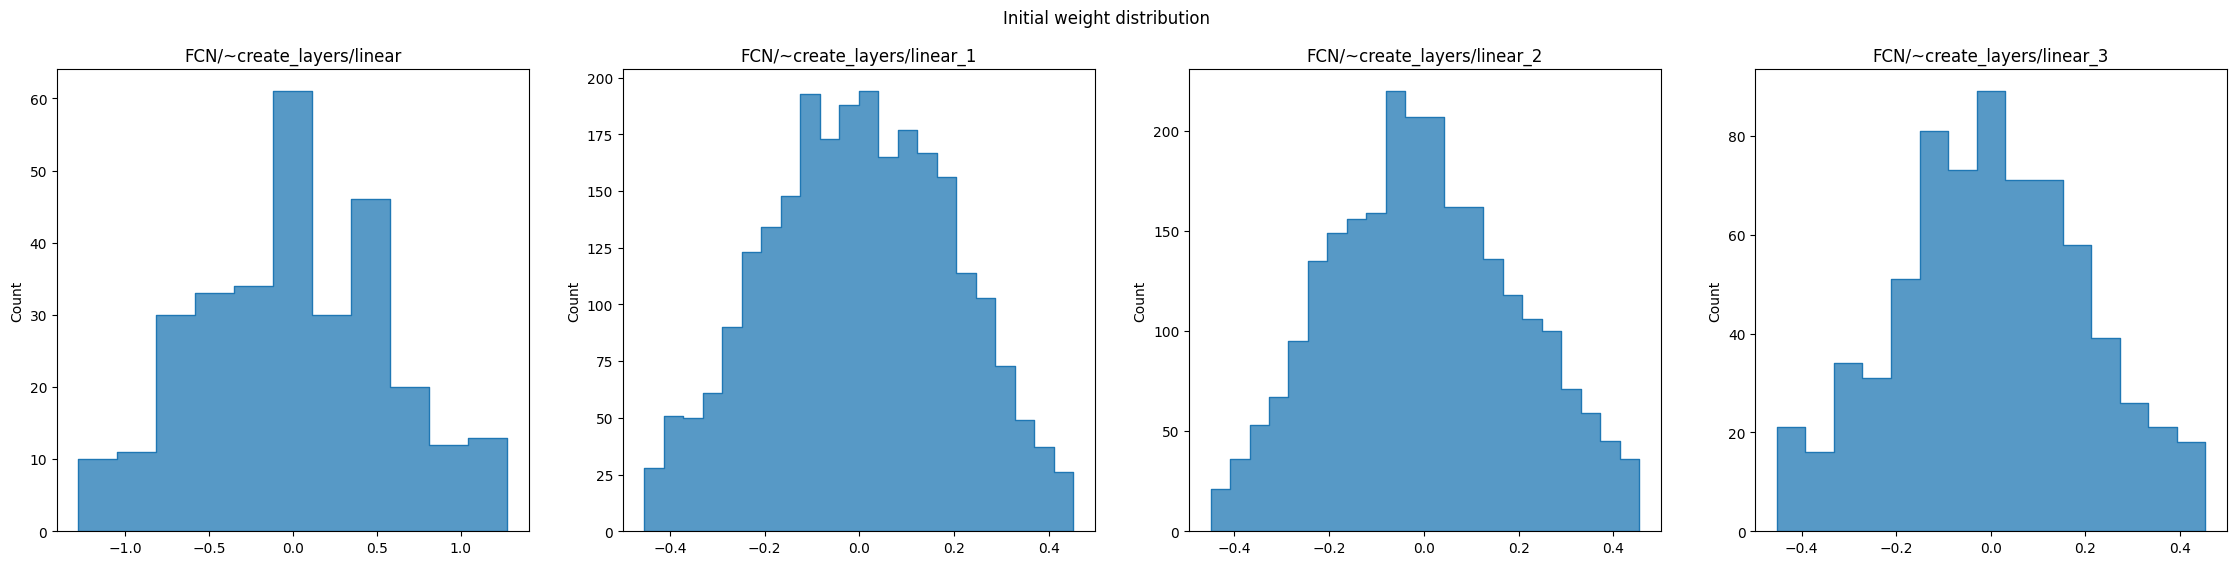

In [15]:
plt.figure(figsize=(7*len(params), 6))
for i in range(len(params)):
    ax = plt.subplot(1, len(params), i+1)
    sns.histplot(params[list(params.keys())[i]]['w'].flatten(), element='step')
    plt.title(list(params.keys())[i])
plt.suptitle('Initial weight distribution')

### Optimiser

In [16]:
if LEARNING_RATE_SCHED == 'cosine_decay':
    learning_rate_scheduler = optax.cosine_decay_schedule(LEARNING_RATE, decay_steps=EPOCHS, alpha=L2_REG_ALPHA)
else:
    learning_rate_scheduler = LEARNING_RATE

warmup_fn = optax.linear_schedule(
    init_value=0., end_value=LEARNING_RATE,
    transition_steps=WARMUP_EPOCHS * N_BATCHES)
cosine_epochs = max(EPOCHS - WARMUP_EPOCHS, 1)
cosine_fn = optax.cosine_decay_schedule(
    init_value=LEARNING_RATE,
    decay_steps=cosine_epochs * N_BATCHES)
schedule_fn = optax.join_schedules(
    schedules=[warmup_fn, cosine_fn],
    boundaries=[WARMUP_EPOCHS * N_BATCHES])


optimiser = optax.sgd(learning_rate=learning_rate_scheduler)
# optimiser = optax.sgd(learning_rate=schedule_fn)
optimiser_state = optimiser.init(x)

## Train

In [17]:
def train_step(params, rng, model, x, y, optimiser, optimiser_state, l2_reg_alpha):

    loss, grads = jax.value_and_grad(loss_fn)(
        params, rng, model, x, y, l2_reg_alpha)

    updates, optimiser_state = optimiser.update(grads, optimiser_state)
    params = optax.apply_updates(params, updates)

    return params, loss / len(x), grads


def eval_step(params, rng, model: FCN, x, y, l2_reg_alpha):
    """ Return the average of loss and accuracy on validation data """
    # pred_y = model.apply(params, rng, x)
    # return accuracy_score(y, jnp.argmax(pred_y, axis=1))
    loss = loss_fn(params, rng, model, x, y, l2_reg_alpha)
    acc = compute_accuracy(params, rng, model, x, y)
    return acc, loss / len(x)


def train(params, rng, model, x_train, y_train, x_val, y_val,
          optimiser, optimiser_state,
          l2_reg_alpha, epochs, batch_size: int,
          save_every: int = 50):
    saves = {}
    n_batches = (x_train.shape[0]//batch_size)+1
    for e in range(epochs):

        for batch in range(n_batches):
            start = int(batch*batch_size)
            end = int((batch+1)*batch_size) if batch != n_batches - 1 else None

            # Single batch of data
            x_batch, y_batch = x_train[start:end], y_train[start:end]

            if len(x_batch) and len(y_batch):
                params, train_loss, grads = train_step(
                    params, rng, model, x_batch, y_batch, optimiser, optimiser_state, l2_reg_alpha)

        val_acc, val_loss = eval_step(
            params, rng, model, x_val, y_val, l2_reg_alpha)

        if np.mod(e, save_every) == 0:
            saves[e] = {
                'params': params,
                'grads': grads,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'val_accuracy': val_acc
            }
            print(
                f'Epoch {e} / {epochs} -\t\t Train loss: {train_loss}\tVal loss: {val_loss}\tVal accuracy: {val_acc}')
    return params, saves

In [18]:
params, saves = train(params, rng, model, x_train, y_train, x_val, y_val, optimiser, optimiser_state,
                      l2_reg_alpha=L2_REG_ALPHA, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                      save_every=PRINT_EVERY) #int(STEPS // 15))

KeyboardInterrupt: 

## Visualise

Text(0.5, 0, 'step')

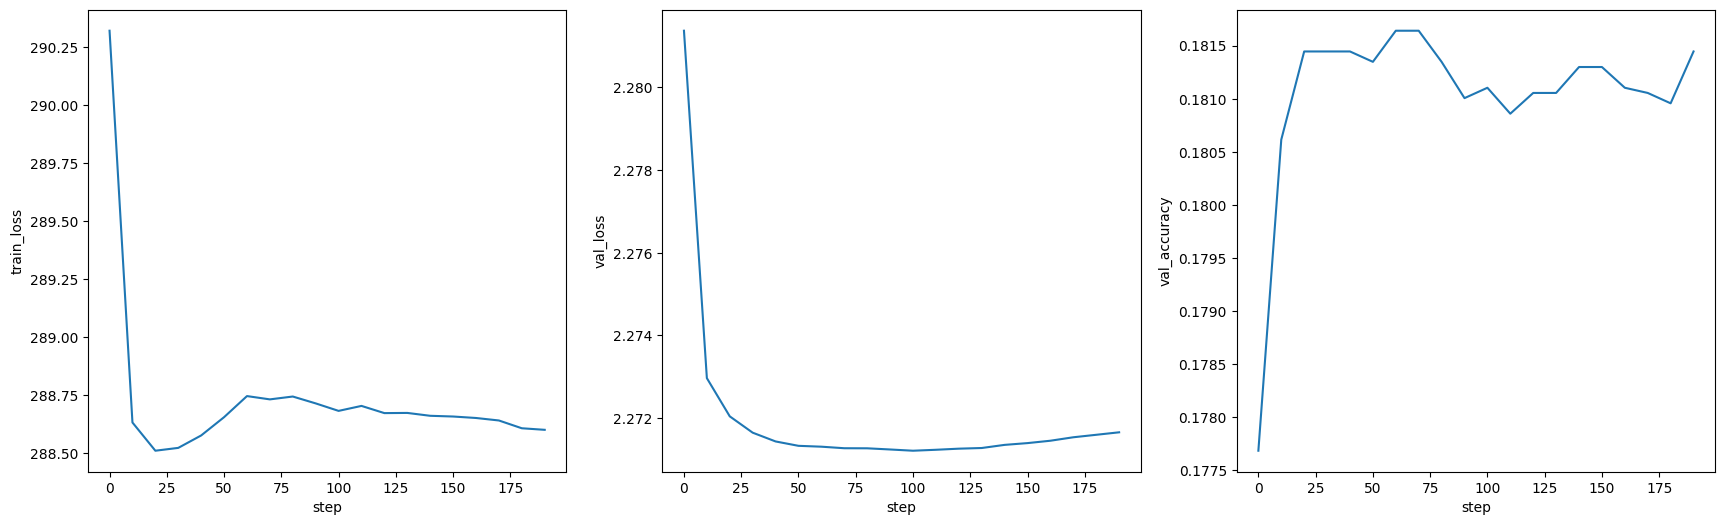

In [ ]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1,3,1)
plt.plot(list(saves.keys()), [v['train_loss'] for v in saves.values()])
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1,3,2)
plt.plot(list(saves.keys()), [v['val_loss'] for v in saves.values()])
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1,3,3)
plt.plot(list(saves.keys()), [v['val_accuracy'] for v in saves.values()])
plt.ylabel('val_accuracy')
plt.xlabel('step')

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


Text(0.5, 0, 'Actual')

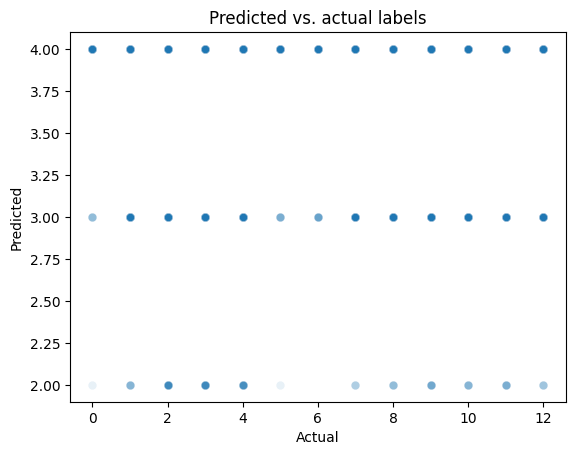

In [ ]:
predicted = model.apply(params, rng, x_val)
predicted = jnp.argmax(predicted, axis=1)

sns.scatterplot(x=y_val, y=predicted, alpha=0.1)
plt.title('Predicted vs. actual labels')
plt.ylabel('Predicted')
plt.xlabel('Actual')


Text(0.5, 0.98, 'Grads: FCN/~create_layers/linear_2')

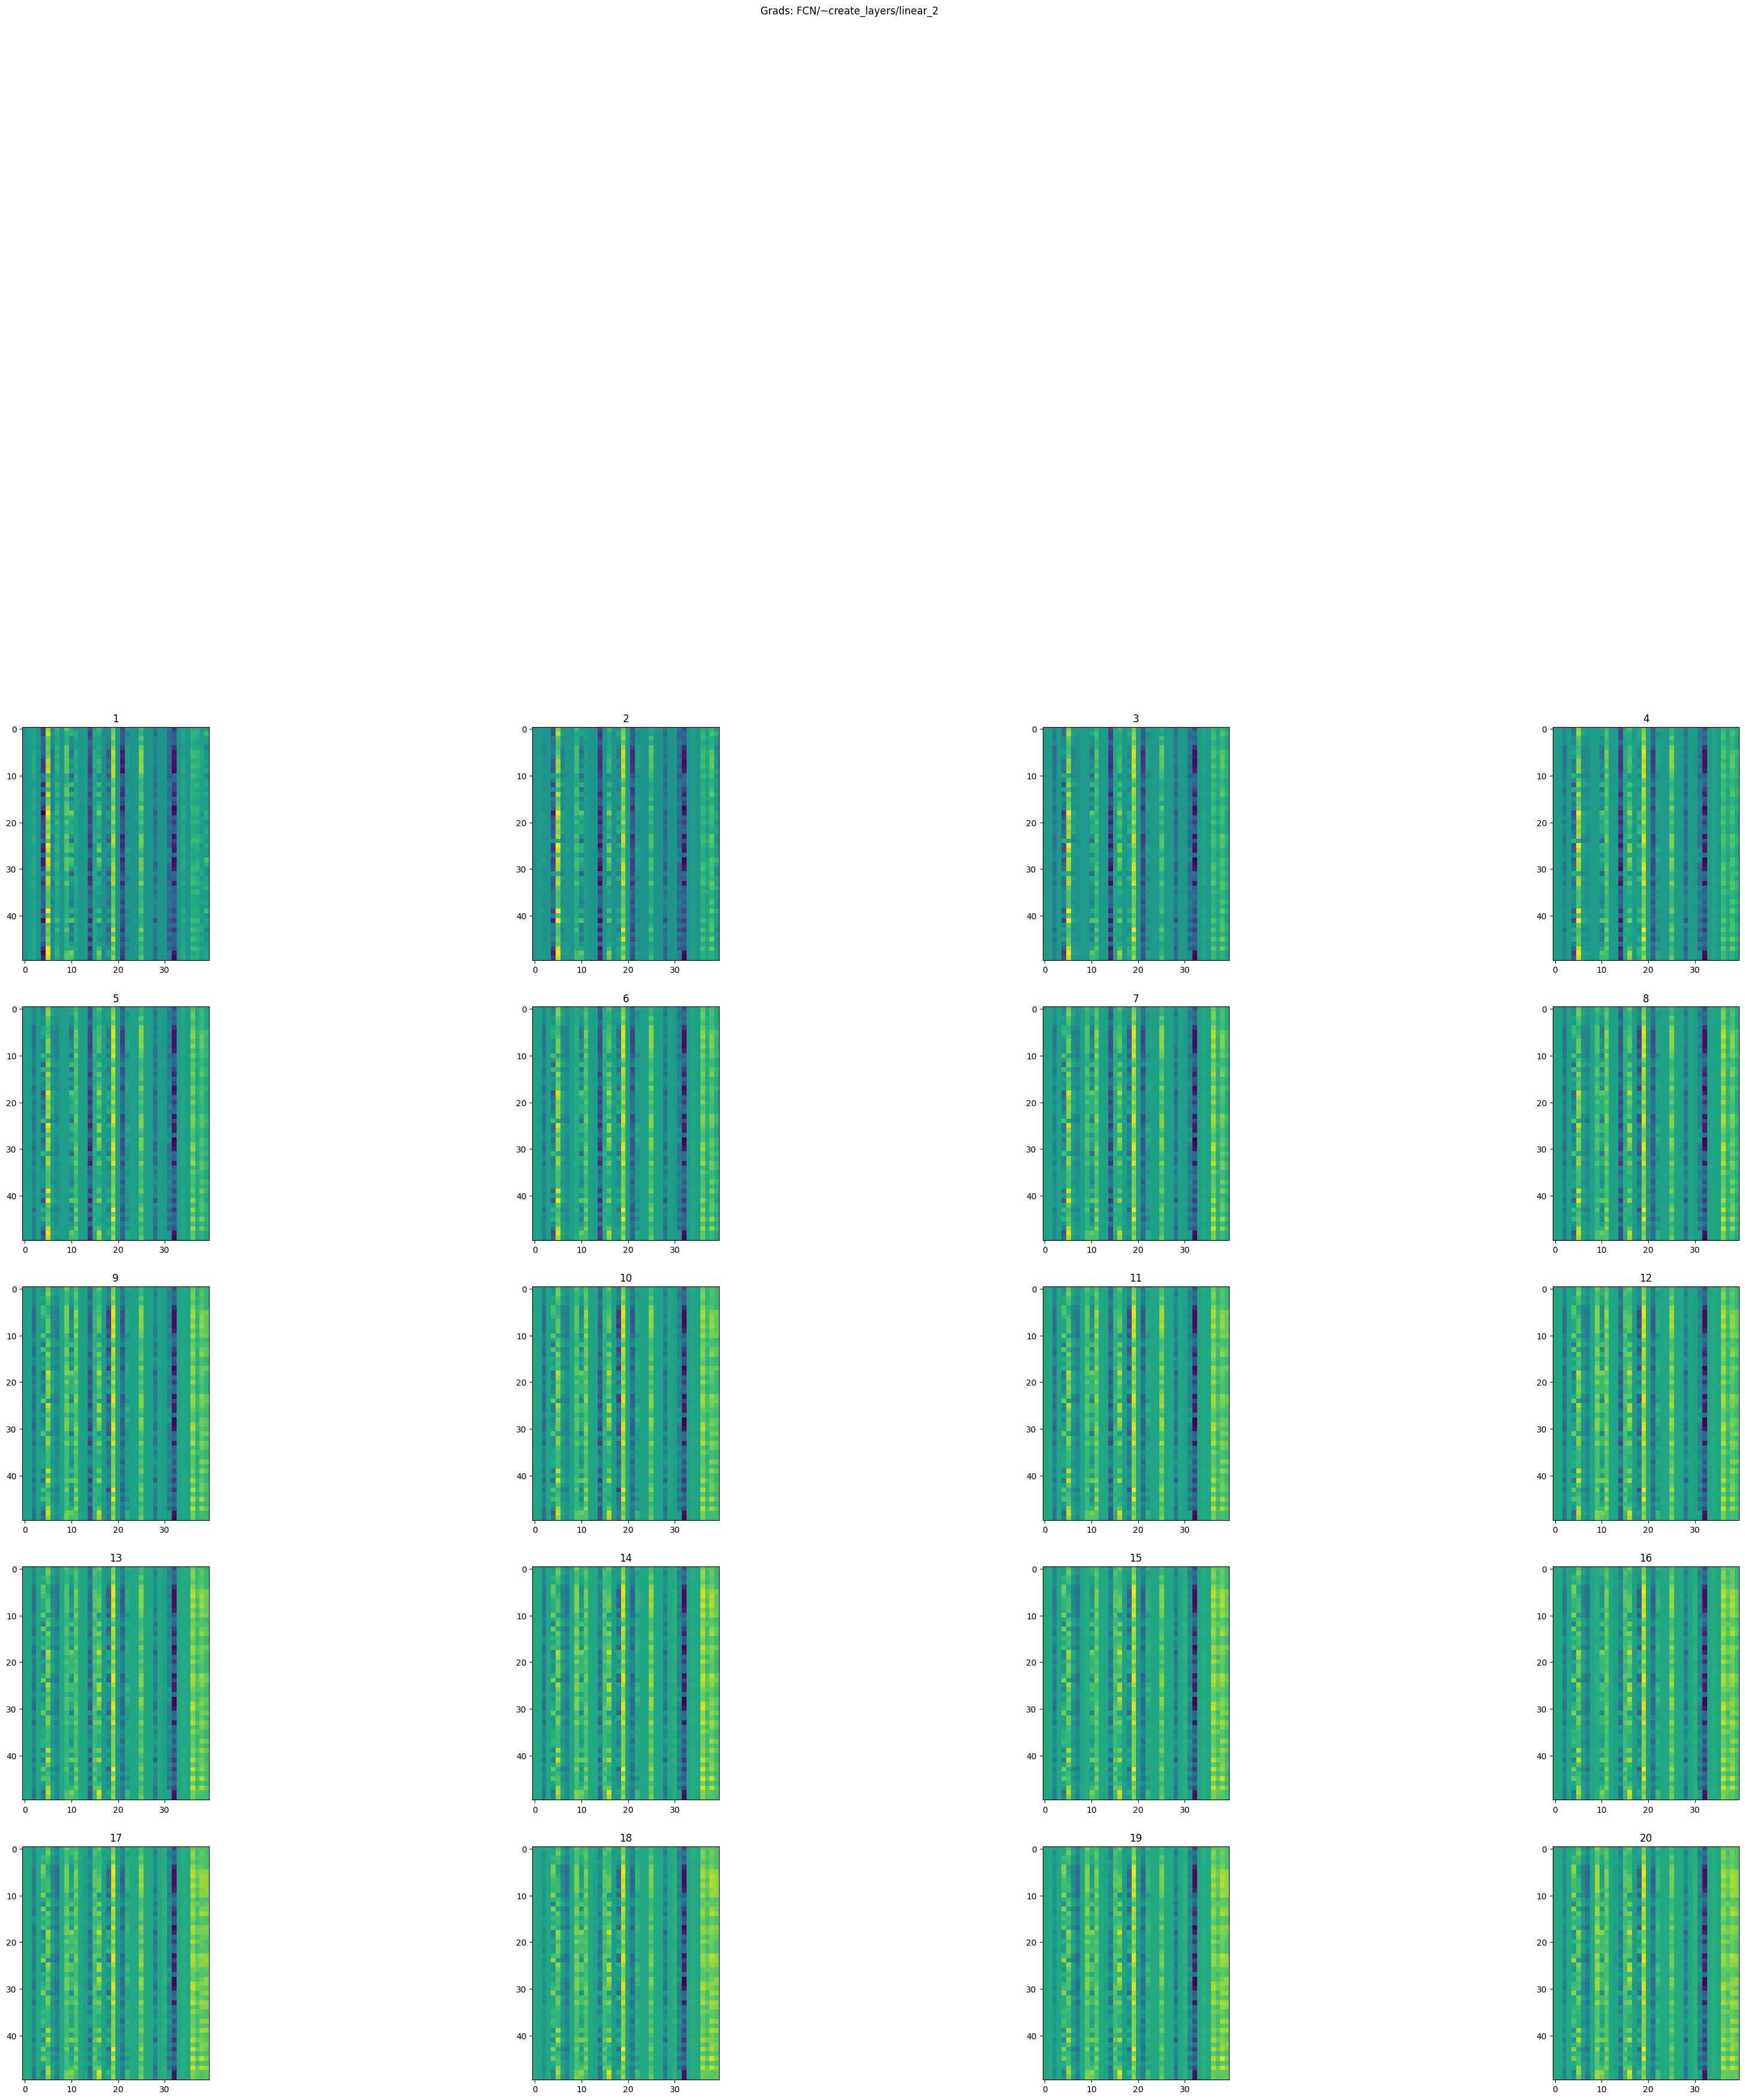

In [ ]:
saves_grads = [v['grads'] for v in saves.values()]

plt.figure(figsize=(6*7, 20*6))
i = 1
layer_to_visualise = list(saves_grads[0].keys())[2]
for s in saves_grads:
    for v in [s[layer_to_visualise]]:
        ax = plt.subplot(len(saves_grads), 4, i)
        plt.imshow(v['w'])
        plt.title(i)
        i += 1
plt.suptitle(f'Grads: {layer_to_visualise}')

Text(0.5, 0.98, 'Param weights: FCN/~create_layers/linear_3')

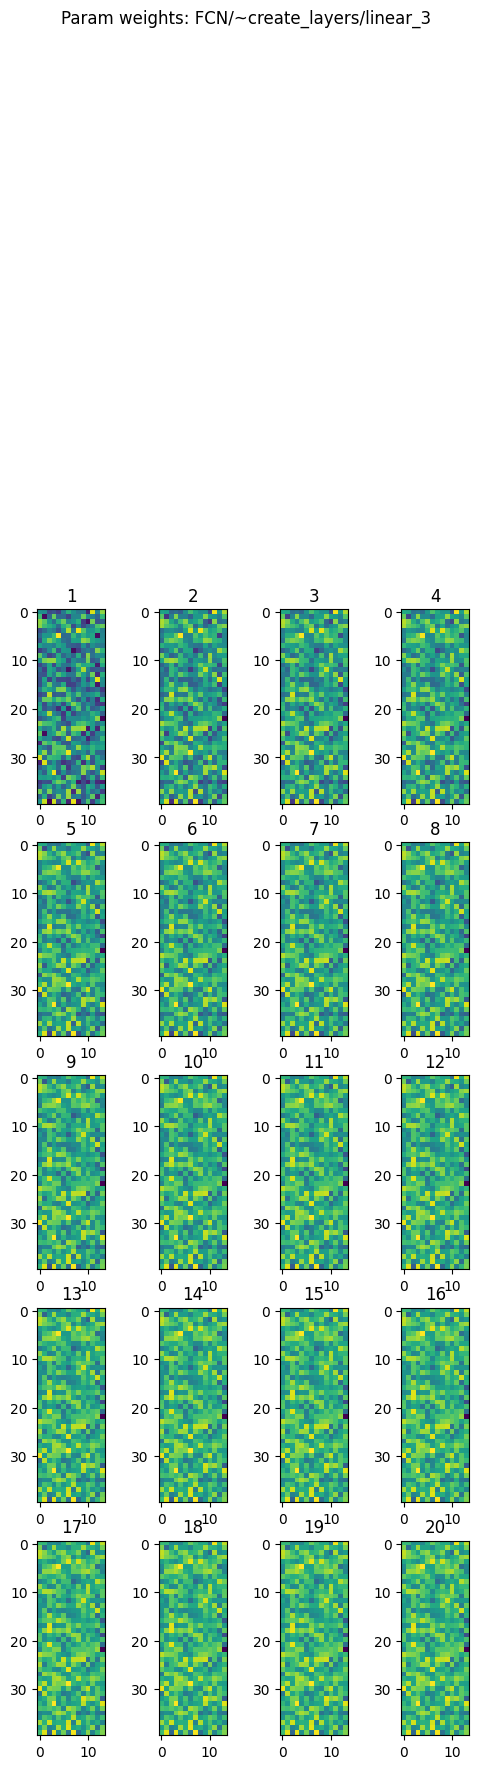

In [ ]:
saves_params = [v['params'] for v in saves.values()]

plt.figure(figsize=(6*1, 10*6))
i = 1
layer_to_visualise = list(saves_params[0].keys())[3]
for s in saves_params:
    for v in [s[layer_to_visualise]]:
        ax = plt.subplot(len(saves_params), 4, i)
        plt.imshow(v['w'])
        plt.title(i)
        i += 1
plt.suptitle(f'Param weights: {layer_to_visualise}')

In [ ]:
plt.savefig('training_summary.png')
write_json(saves, out_path='saves')


<Figure size 640x480 with 0 Axes>